# IAA - Cirrhosis Laboratory Report

En aquest notebook es pot trobar la implementació de la pràctica de Cirrosi realitzada per en Jaume Mora per a l’assignatura d’Introducció a l’Aprenentatge Automàtic.

IMPORTANT!!! Si falla l'execució de les dues primeres cel·les, esborreu-les o comenteu-les, són per a l'instal·lació de Model Card ToolKit:

In [1]:
%%shell
update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 3
curl -O https://bootstrap.pypa.io/get-pip.py
python get-pip.py

UsageError: Cell magic `%%shell` not found.


In [ ]:
%pip install model-card-toolkit --use-deprecated=legacy-resolver

In [ ]:
import model_card_toolkit as mct

In [ ]:
%pip install imblearn ucimlrepo pandas numpy matplotlib tabulate scikit-learn seaborn fancyimpute markdown interpret

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import base64


from io import BytesIO
from IPython import display
from datetime import date
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tabulate import tabulate




In [ ]:
def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878)

# data (as pandas dataframes)
X = cirrhosis_patient_survival_prediction.data.original
y = cirrhosis_patient_survival_prediction.data.targets

# metadata
print(cirrhosis_patient_survival_prediction.metadata)

# variable information
print(cirrhosis_patient_survival_prediction.variables)

{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'title': 'Prognos

In [ ]:
df = pd.DataFrame(X,  cirrhosis_patient_survival_prediction.original)
df.shape
df.sample(10,random_state=42)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
321,322,2011,D,NaN,23376,F,NaN,NaN,NaN,N,1.1,NaN,3.69,NaN,NaN,NaN,NaN,139,10.5,NaN
324,325,4795,C,NaN,12419,F,NaN,NaN,NaN,N,1.8,NaN,3.24,NaN,NaN,NaN,NaN,NaN,18.0,2.0
388,389,1581,C,NaN,24472,F,NaN,NaN,NaN,N,0.7,NaN,3.06,NaN,NaN,NaN,NaN,165,10.0,4.0
56,57,3282,D,D-penicillamine,19567,F,N,Y,N,S,2.3,260,3.18,231,11320.2,105.78,94,216,12.4,3.0
153,154,140,D,D-penicillamine,25340,M,N,N,Y,Y,2.4,168,2.56,225,1056.0,120.90,75,108,14.1,3.0
30,31,3839,D,Placebo,15177,F,N,Y,N,N,4.7,296,3.44,114,9933.2,206.40,101,195,10.3,2.0
72,73,4190,C,Placebo,14060,F,N,N,N,N,0.7,132,3.60,17,423.0,49.60,56,265,11.0,1.0
82,83,4050,C,D-penicillamine,20459,F,N,Y,N,S,1.3,250,3.50,48,1138.0,71.30,100,81,12.9,4.0
258,259,1615,C,Placebo,21904,F,N,Y,N,N,3.1,277,2.97,42,1110.0,125.00,126,221,9.8,3.0
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269,10.4,3.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           313 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        313 non-null    object 
 7   Hepatomegaly   313 non-null    object 
 8   Spiders        313 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    312 non-null    object 
 12  Albumin        418 non-null    float64
 13  Copper         312 non-null    object 
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  312 non-null    object 
 17  Platelets      411 non-null    object 
 18  Prothrombi

In [ ]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                                         columns=['col_name', 'unique']).sort_values(by=['unique'])
unique_counts

,col_name,unique
5,Sex,2
9,Edema,3
8,Spiders,3
2,Status,3
3,Drug,3
7,Hepatomegaly,3
6,Ascites,3
19,Stage,4
18,Prothrombin,48
10,Bilirubin,98


## SECCIÓ 1. Anàlisi i preprocessat de dades

In [ ]:
# Faig aquest codi perquè se'm passi tot a float i se'm tractin bé els missings que sinó em donava error més tard
df['Cholesterol'] = pd.to_numeric(df['Cholesterol'], errors='coerce')
df['Copper'] = pd.to_numeric(df['Copper'], errors='coerce')
df['Tryglicerides'] = pd.to_numeric(df['Tryglicerides'], errors='coerce')
df['Platelets'] = pd.to_numeric(df['Platelets'], errors='coerce')

### 1.1 i 1.2 Anàlisi de les variables (plots de distribució) i estudi del balanceig:

Anàlisi de la variable N_Days
+--------+---------+---------+---------+-------+---------+-------+--------+-------+
|        |   count |    mean |     std |   min |     25% |   50% |    75% |   max |
|--------+---------+---------+---------+-------+---------+-------+--------+-------|
| N_Days |     418 | 1917.78 | 1104.67 |    41 | 1092.75 |  1730 | 2613.5 |  4795 |
+--------+---------+---------+---------+-------+---------+-------+--------+-------+


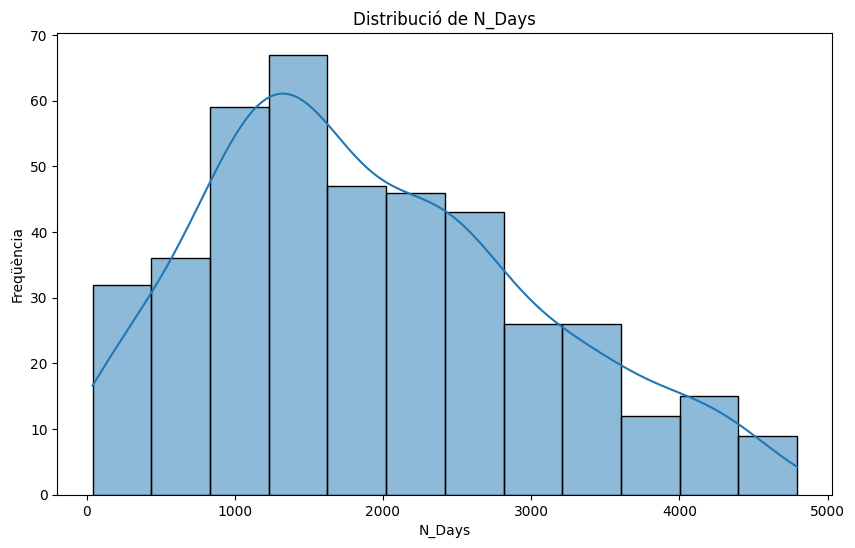

Anàlisi de la variable Status
+--------+---------+----------+-------+--------+
|        |   count |   unique | top   |   freq |
|--------+---------+----------+-------+--------|
| Status |     418 |        3 | C     |    232 |
+--------+---------+----------+-------+--------+


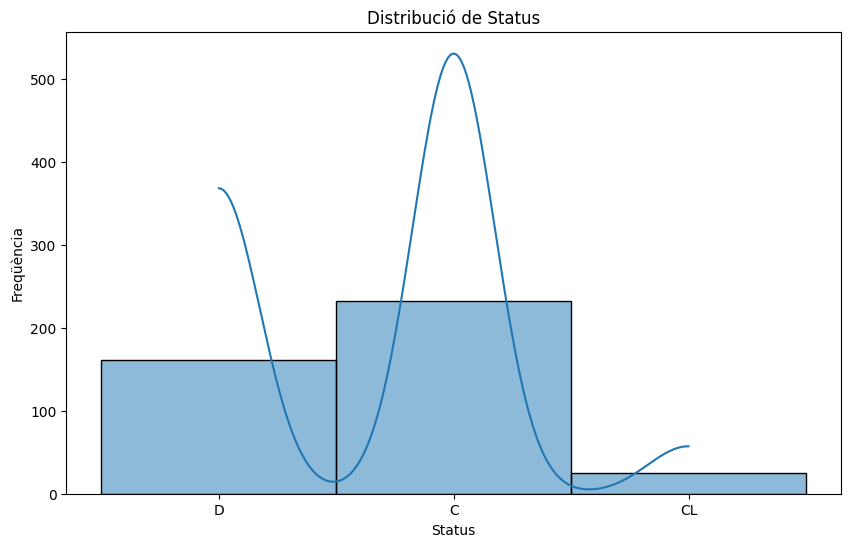

Anàlisi de la variable Drug
+------+---------+----------+-----------------+--------+
|      |   count |   unique | top             |   freq |
|------+---------+----------+-----------------+--------|
| Drug |     313 |        3 | D-penicillamine |    158 |
+------+---------+----------+-----------------+--------+


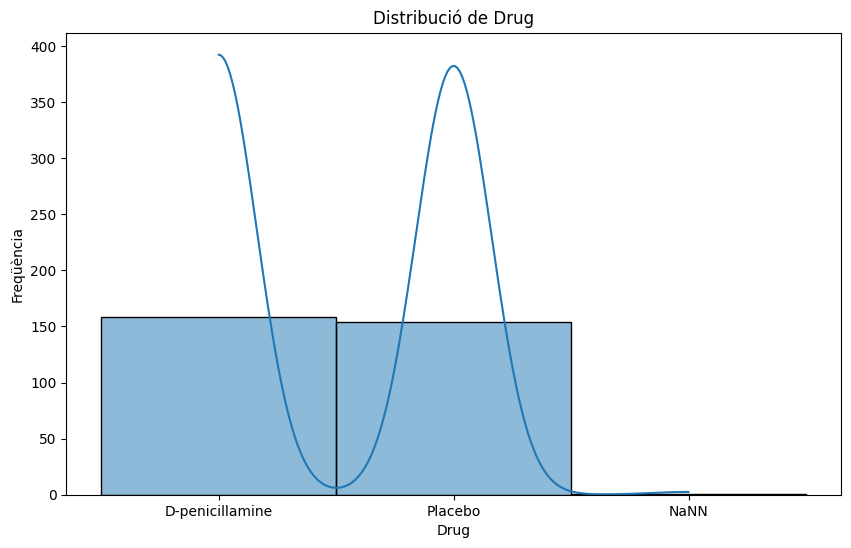

Anàlisi de la variable Age
+-----+---------+---------+---------+-------+---------+-------+---------+-------+
|     |   count |    mean |     std |   min |     25% |   50% |     75% |   max |
|-----+---------+---------+---------+-------+---------+-------+---------+-------|
| Age |     418 | 18533.4 | 3815.85 |  9598 | 15644.5 | 18628 | 21272.5 | 28650 |
+-----+---------+---------+---------+-------+---------+-------+---------+-------+


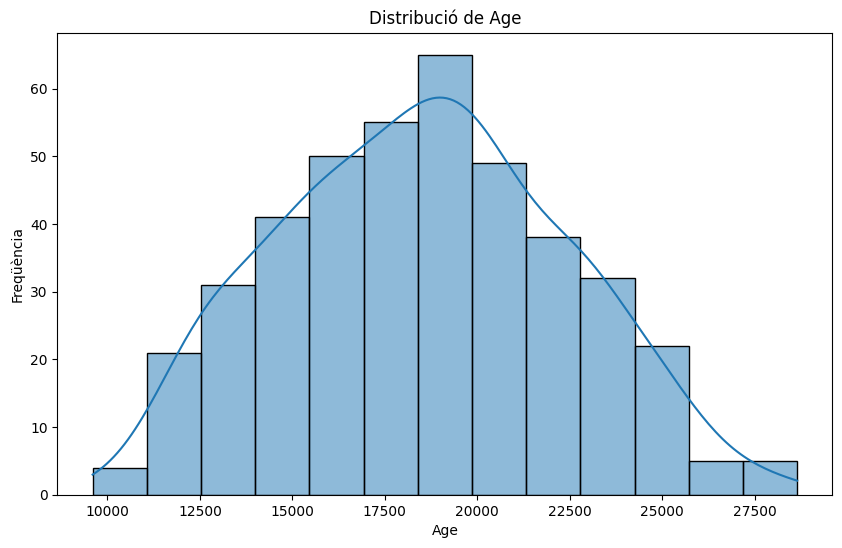

Anàlisi de la variable Sex
+-----+---------+----------+-------+--------+
|     |   count |   unique | top   |   freq |
|-----+---------+----------+-------+--------|
| Sex |     418 |        2 | F     |    374 |
+-----+---------+----------+-------+--------+


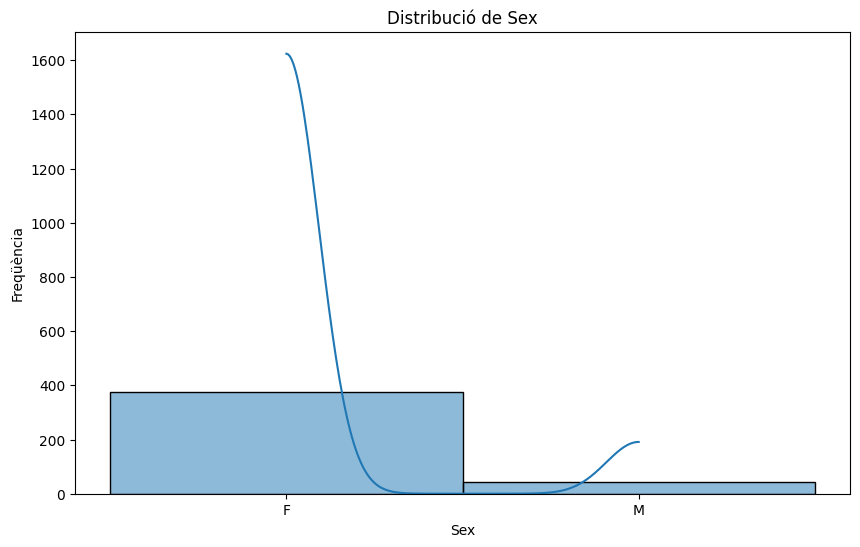

Anàlisi de la variable Ascites
+---------+---------+----------+-------+--------+
|         |   count |   unique | top   |   freq |
|---------+---------+----------+-------+--------|
| Ascites |     313 |        3 | N     |    288 |
+---------+---------+----------+-------+--------+


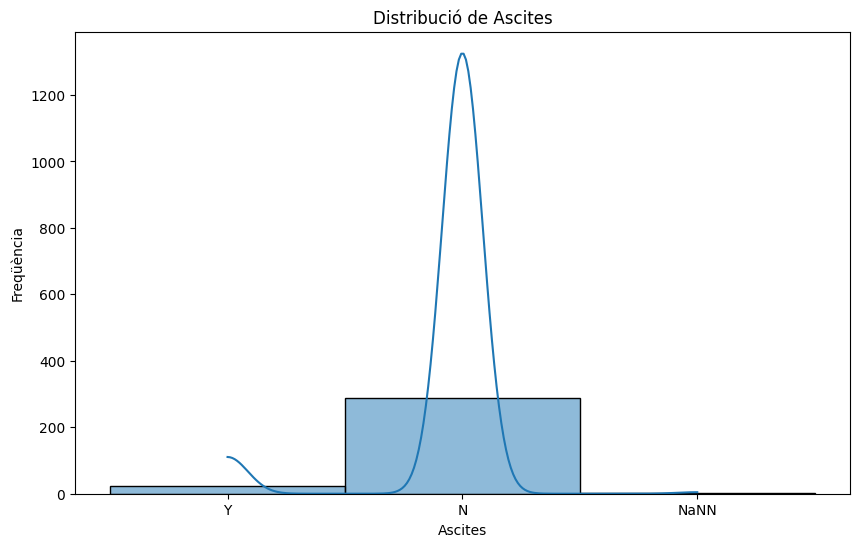

Anàlisi de la variable Hepatomegaly
+--------------+---------+----------+-------+--------+
|              |   count |   unique | top   |   freq |
|--------------+---------+----------+-------+--------|
| Hepatomegaly |     313 |        3 | Y     |    160 |
+--------------+---------+----------+-------+--------+


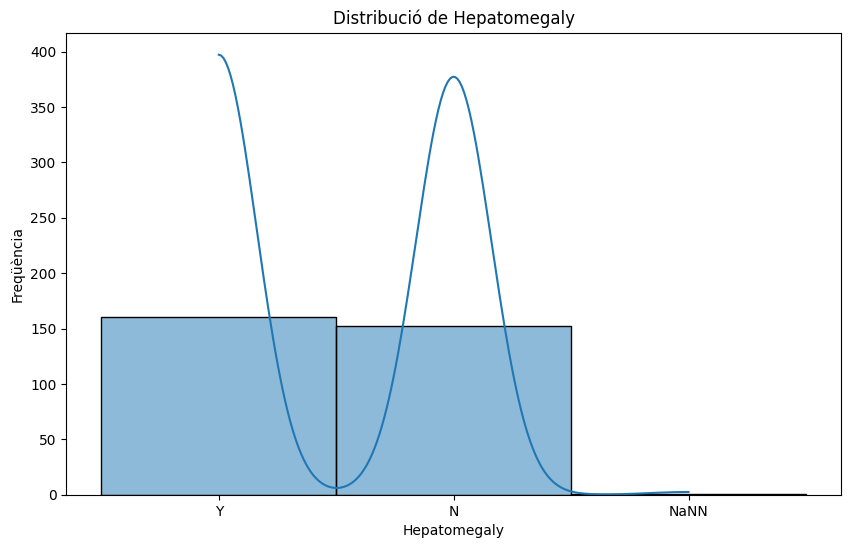

Anàlisi de la variable Spiders
+---------+---------+----------+-------+--------+
|         |   count |   unique | top   |   freq |
|---------+---------+----------+-------+--------|
| Spiders |     313 |        3 | N     |    222 |
+---------+---------+----------+-------+--------+


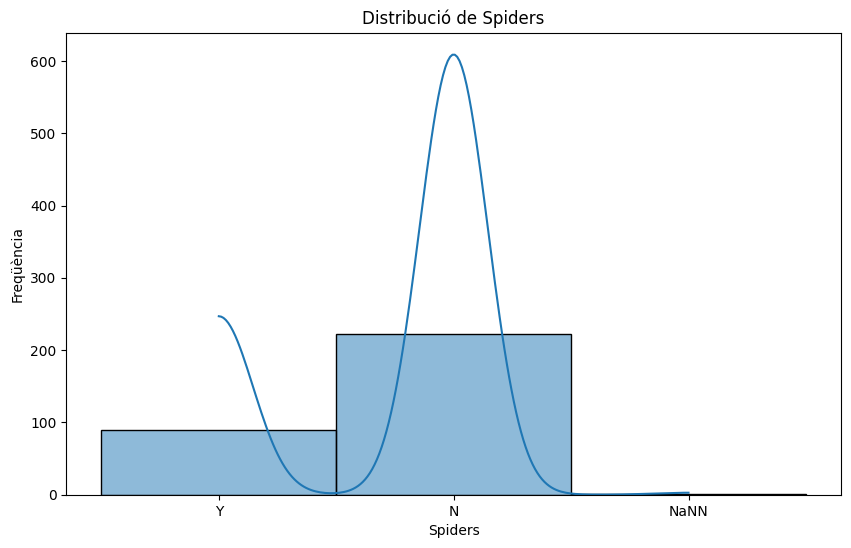

Anàlisi de la variable Edema
+-------+---------+----------+-------+--------+
|       |   count |   unique | top   |   freq |
|-------+---------+----------+-------+--------|
| Edema |     418 |        3 | N     |    354 |
+-------+---------+----------+-------+--------+


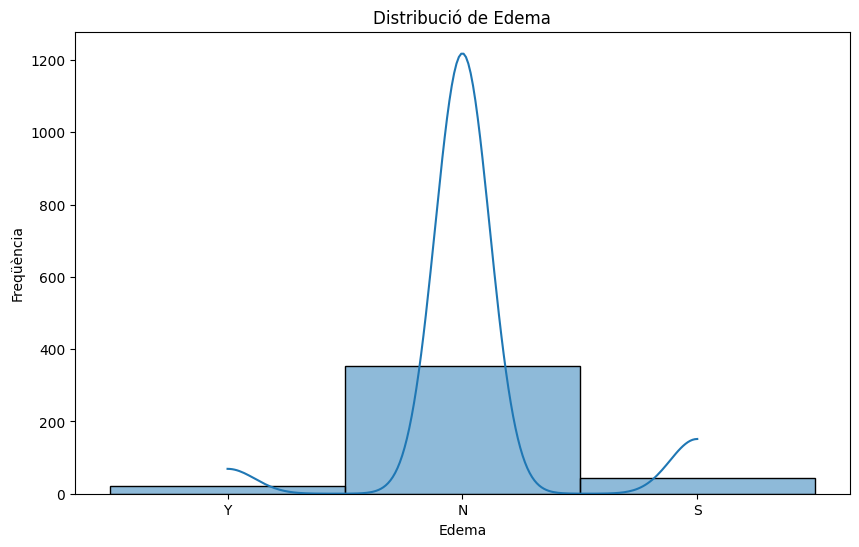

Anàlisi de la variable Bilirubin
+-----------+---------+---------+---------+-------+-------+-------+-------+-------+
|           |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|-----------+---------+---------+---------+-------+-------+-------+-------+-------|
| Bilirubin |     418 | 3.22081 | 4.40751 |   0.3 |   0.8 |   1.4 |   3.4 |    28 |
+-----------+---------+---------+---------+-------+-------+-------+-------+-------+


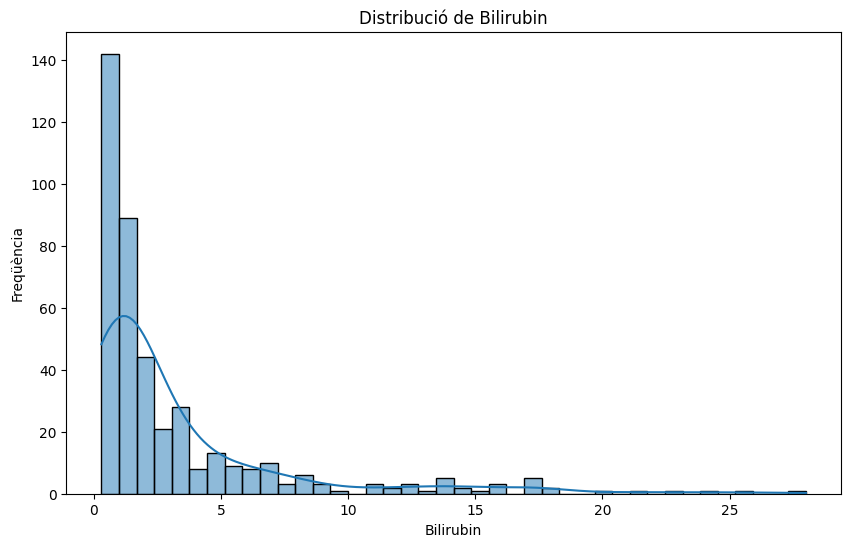

Anàlisi de la variable Cholesterol
+-------------+---------+---------+---------+-------+-------+-------+-------+-------+
|             |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|-------------+---------+---------+---------+-------+-------+-------+-------+-------|
| Cholesterol |     284 | 369.511 | 231.945 |   120 | 249.5 | 309.5 |   400 |  1775 |
+-------------+---------+---------+---------+-------+-------+-------+-------+-------+


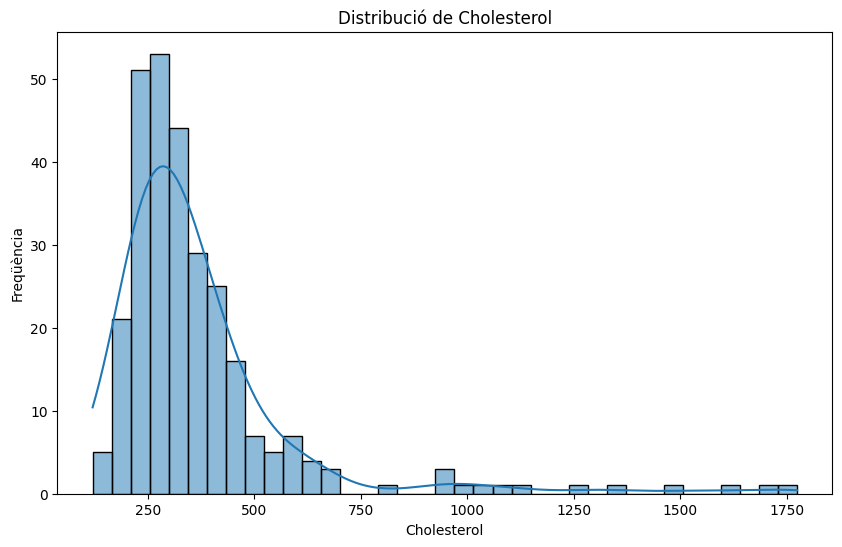

Anàlisi de la variable Albumin
+---------+---------+---------+----------+-------+--------+-------+-------+-------+
|         |   count |    mean |      std |   min |    25% |   50% |   75% |   max |
|---------+---------+---------+----------+-------+--------+-------+-------+-------|
| Albumin |     418 | 3.49744 | 0.424972 |  1.96 | 3.2425 |  3.53 |  3.77 |  4.64 |
+---------+---------+---------+----------+-------+--------+-------+-------+-------+


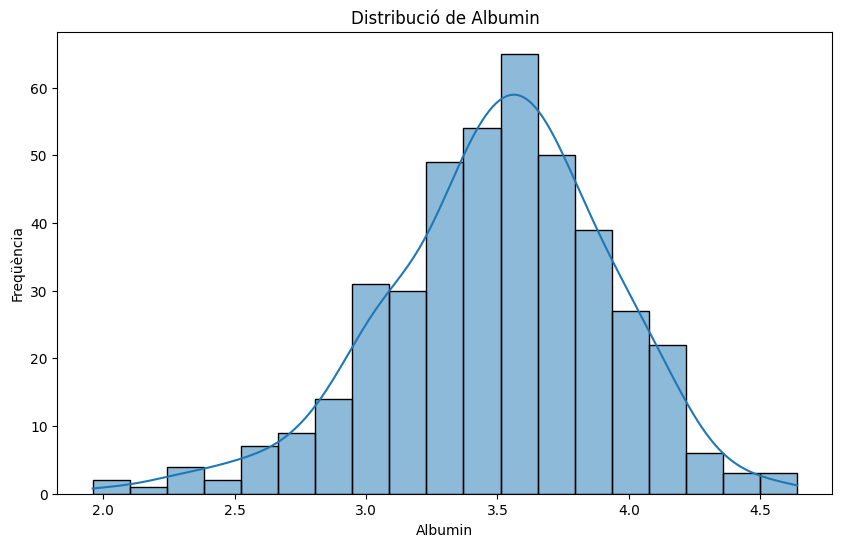

Anàlisi de la variable Copper
+--------+---------+---------+---------+-------+-------+-------+-------+-------+
|        |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|--------+---------+---------+---------+-------+-------+-------+-------+-------|
| Copper |     310 | 97.6484 | 85.6139 |     4 | 41.25 |    73 |   123 |   588 |
+--------+---------+---------+---------+-------+-------+-------+-------+-------+


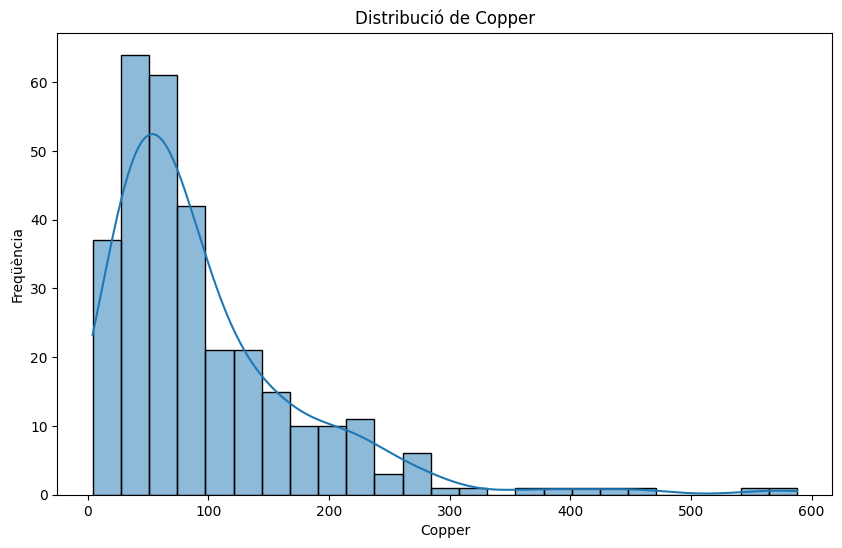

Anàlisi de la variable Alk_Phos
+----------+---------+---------+---------+-------+-------+-------+-------+---------+
|          |   count |    mean |     std |   min |   25% |   50% |   75% |     max |
|----------+---------+---------+---------+-------+-------+-------+-------+---------|
| Alk_Phos |     312 | 1982.66 | 2140.39 |   289 | 871.5 |  1259 |  1980 | 13862.4 |
+----------+---------+---------+---------+-------+-------+-------+-------+---------+


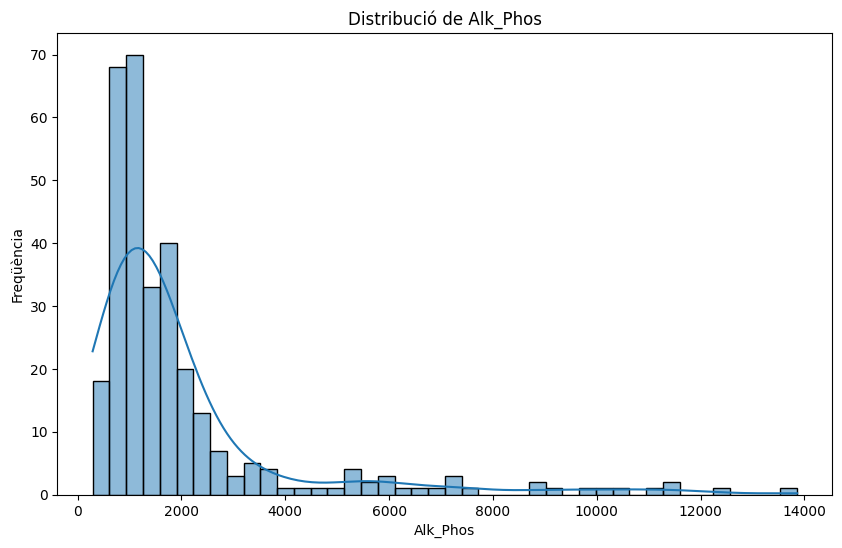

Anàlisi de la variable SGOT
+------+---------+---------+---------+-------+-------+-------+-------+--------+
|      |   count |    mean |     std |   min |   25% |   50% |   75% |    max |
|------+---------+---------+---------+-------+-------+-------+-------+--------|
| SGOT |     312 | 122.556 | 56.6995 | 26.35 |  80.6 | 114.7 | 151.9 | 457.25 |
+------+---------+---------+---------+-------+-------+-------+-------+--------+


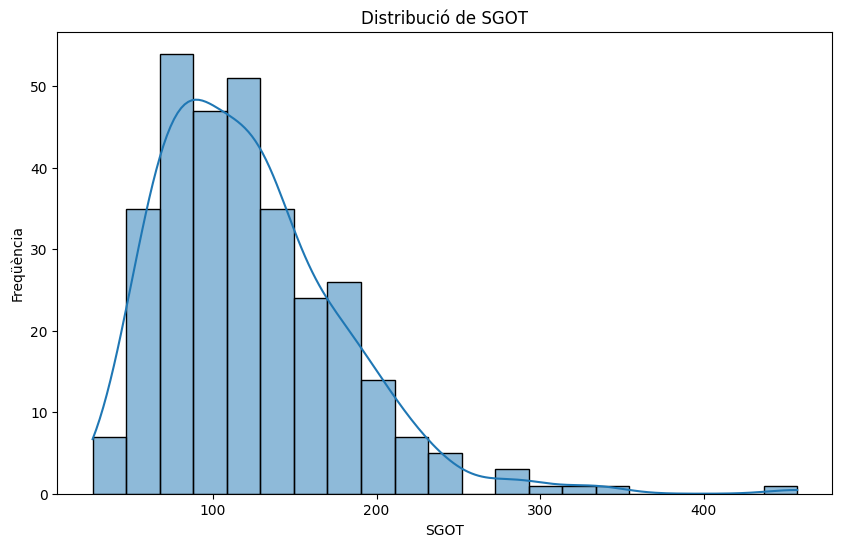

Anàlisi de la variable Tryglicerides
+---------------+---------+---------+---------+-------+-------+-------+-------+-------+
|               |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|---------------+---------+---------+---------+-------+-------+-------+-------+-------|
| Tryglicerides |     282 | 124.702 | 65.1486 |    33 | 84.25 |   108 |   151 |   598 |
+---------------+---------+---------+---------+-------+-------+-------+-------+-------+


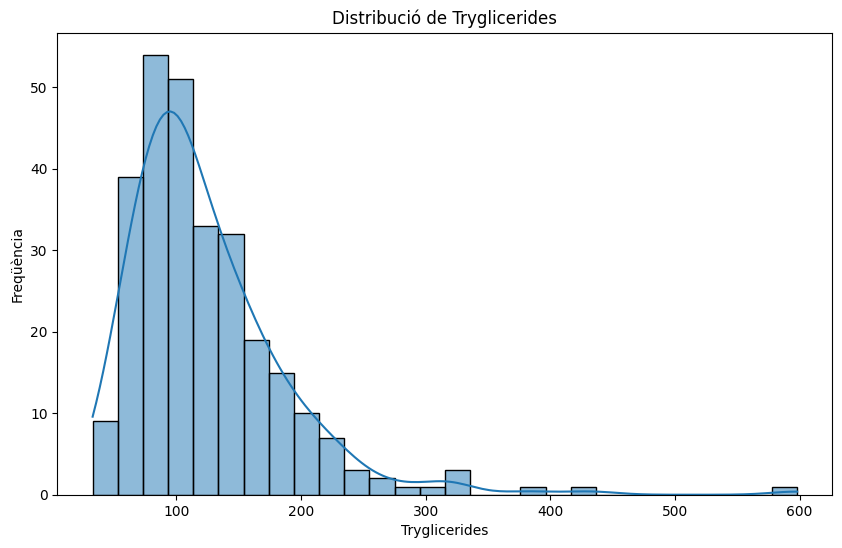

Anàlisi de la variable Platelets
+-----------+---------+---------+---------+-------+-------+-------+-------+-------+
|           |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|-----------+---------+---------+---------+-------+-------+-------+-------+-------|
| Platelets |     407 | 257.025 | 98.3256 |    62 | 188.5 |   251 |   318 |   721 |
+-----------+---------+---------+---------+-------+-------+-------+-------+-------+


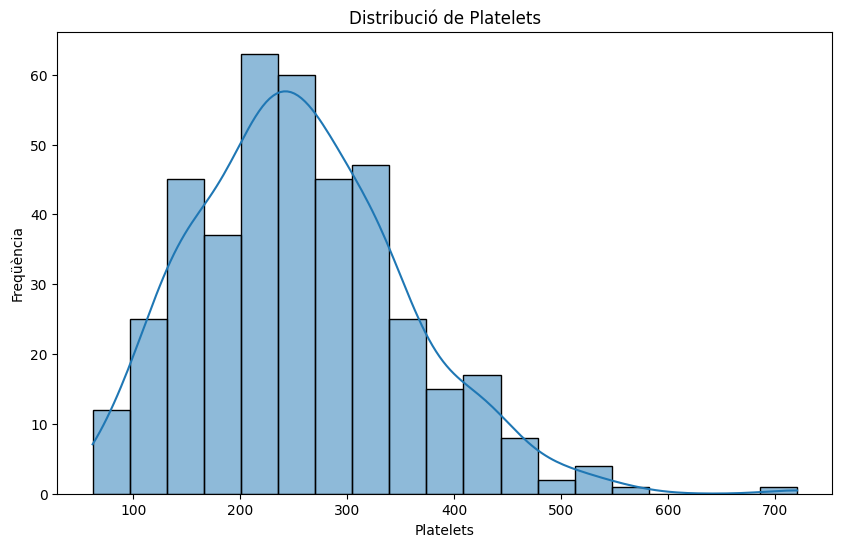

Anàlisi de la variable Prothrombin
+-------------+---------+---------+-------+-------+-------+-------+-------+-------+
|             |   count |    mean |   std |   min |   25% |   50% |   75% |   max |
|-------------+---------+---------+-------+-------+-------+-------+-------+-------|
| Prothrombin |     416 | 10.7317 | 1.022 |     9 |    10 |  10.6 |  11.1 |    18 |
+-------------+---------+---------+-------+-------+-------+-------+-------+-------+


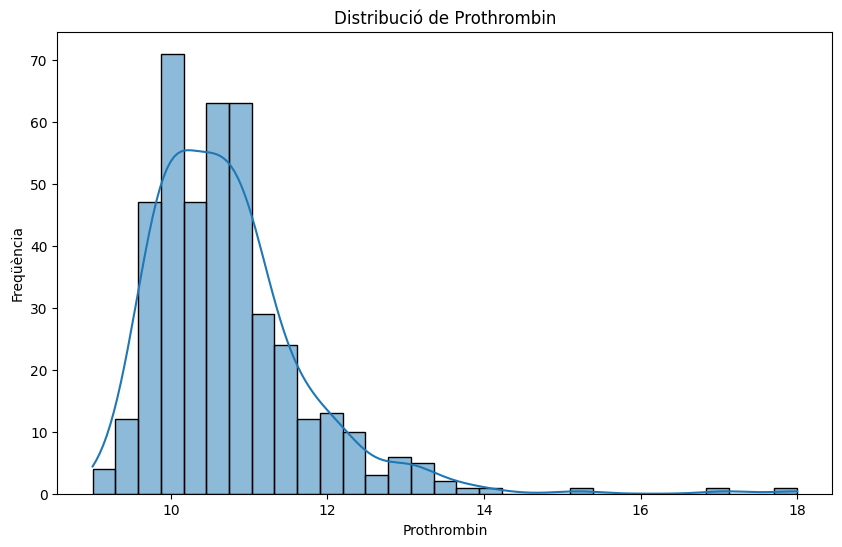

Anàlisi de la variable Stage
+-------+---------+---------+----------+-------+-------+-------+-------+-------+
|       |   count |    mean |      std |   min |   25% |   50% |   75% |   max |
|-------+---------+---------+----------+-------+-------+-------+-------+-------|
| Stage |     412 | 3.02427 | 0.882042 |     1 |     2 |     3 |     4 |     4 |
+-------+---------+---------+----------+-------+-------+-------+-------+-------+


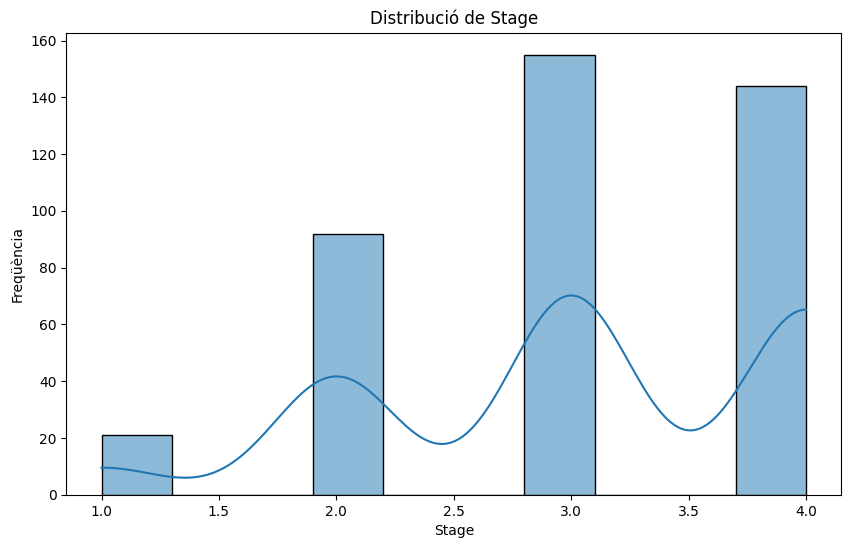

In [ ]:
# creo un vector de strings amb els noms de totes les variables
all_variables = ['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

# creo un for que em recorri les variables
for var in all_variables:
    print('Anàlisi de la variable ' + var)
    # Estadístiques per a cada variable
    print(tabulate(df[var].describe().to_frame().T, headers='keys', tablefmt='psql'))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=var, kde=True)
    plt.title('Distribució de ' + var)
    plt.xlabel(var)
    plt.ylabel('Freqüència')
    plt.show()

Eliminem la variable ID vist que només és un identificador que ens pot aportar soroll:

In [ ]:
df = df.drop('ID', axis=1)

### 1.3.1 Identificació de missings:

In [ ]:
#Número total de missings per variable
print('Número total de missings per variable:')

for var in all_variables:
    print(var + ': ' + str(df[var].isna().sum()))

Número total de missings per variable:
N_Days: 0
Status: 0
Drug: 105
Age: 0
Sex: 0
Ascites: 105
Hepatomegaly: 105
Spiders: 105
Edema: 0
Bilirubin: 0
Cholesterol: 134
Albumin: 0
Copper: 108
Alk_Phos: 106
SGOT: 106
Tryglicerides: 136
Platelets: 11
Prothrombin: 2
Stage: 6


### 1.4 Identificació i gestió dels outliers:

In [ ]:
# Primer hem de separar les variables numèriques de les categòriques
numeric_variables = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

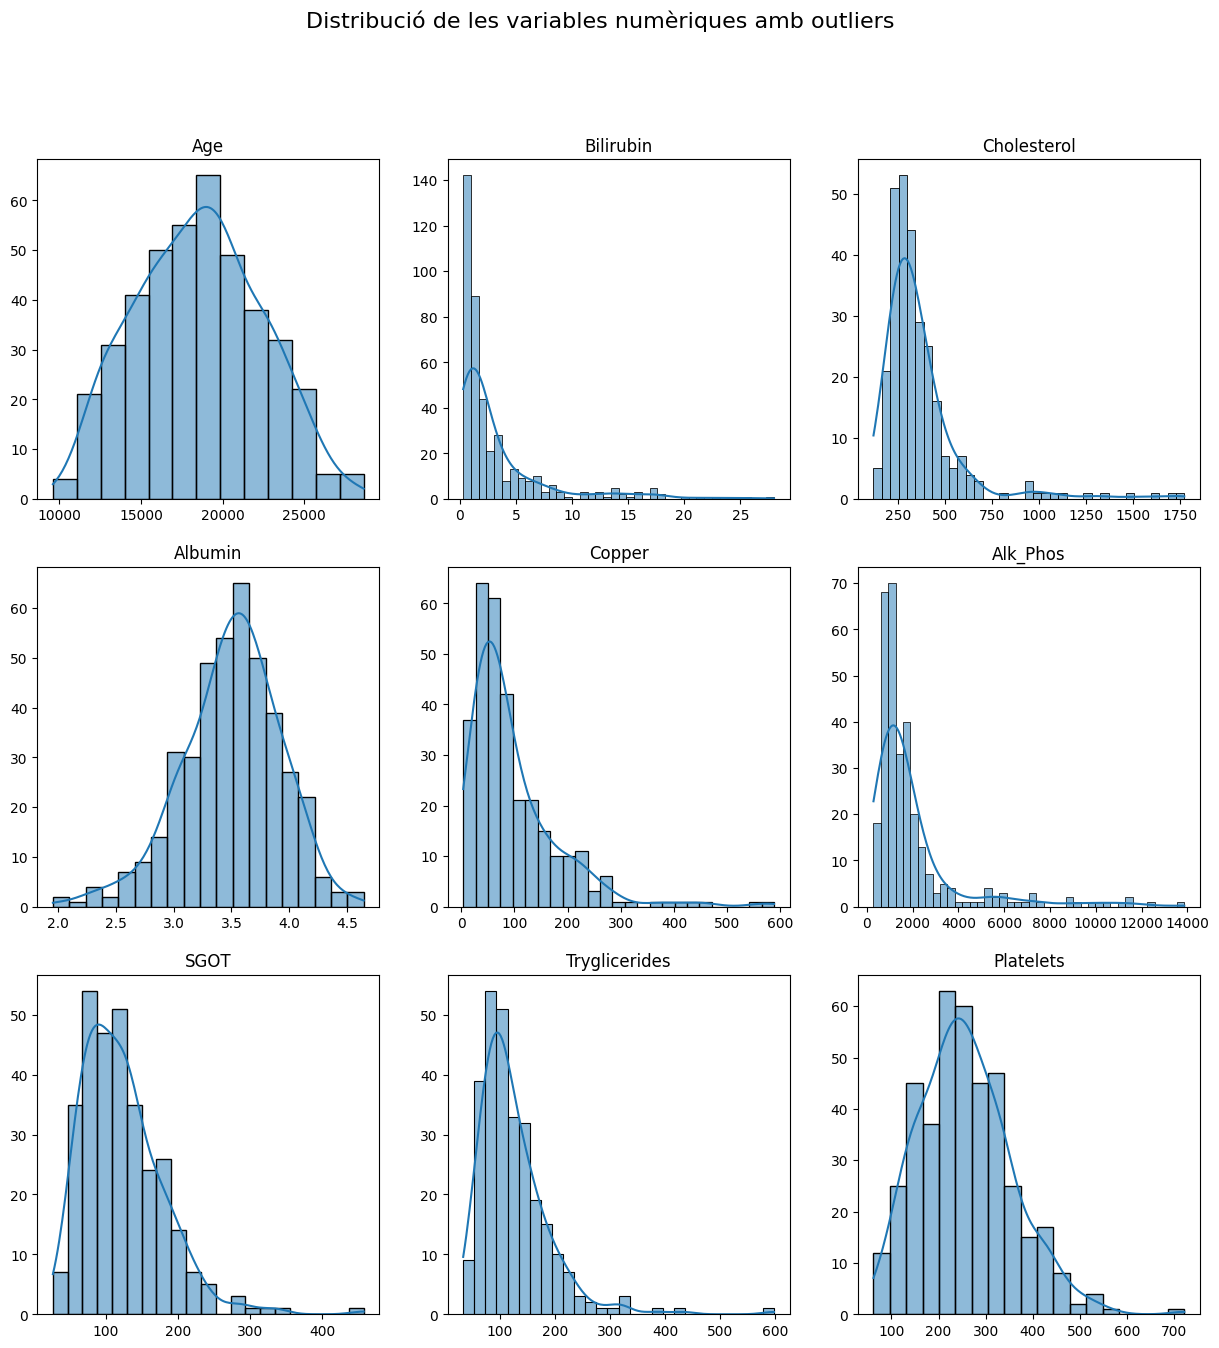

In [ ]:
# Creo una figura que tindrà 9 gràfics de distribució de les variables numèriques
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribució de les variables numèriques amb outliers', fontsize=16)

# Creo un for que em recorri les variables numèriques
for ax, var in zip(axes.flatten(), numeric_variables):
    sns.histplot(data=df, x=var, kde=True, ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')
    ax.set_ylabel('')

var_out = plot_to_str()

In [ ]:
# A coninuació treurem els outliers de les variables numèriques

# Calculo l'IQR per cada columna
Q1 = df[numeric_variables].quantile(0.25)
Q3 = df[numeric_variables].quantile(0.75)
IQR = Q3 - Q1

# Identifico els outliers
outliers = (df[numeric_variables] < (Q1 - 1.5 * IQR)) | (df[numeric_variables] > (Q3 + 1.5 * IQR))

# Imprimeixo el nom de les columnes que tenen outliers
print(outliers.any())

# Convertim els outliers a NaN
df[outliers] = np.nan

Age              False
Bilirubin         True
Cholesterol       True
Albumin           True
Copper            True
Alk_Phos          True
SGOT              True
Tryglicerides     True
Platelets         True
Prothrombin       True
dtype: bool


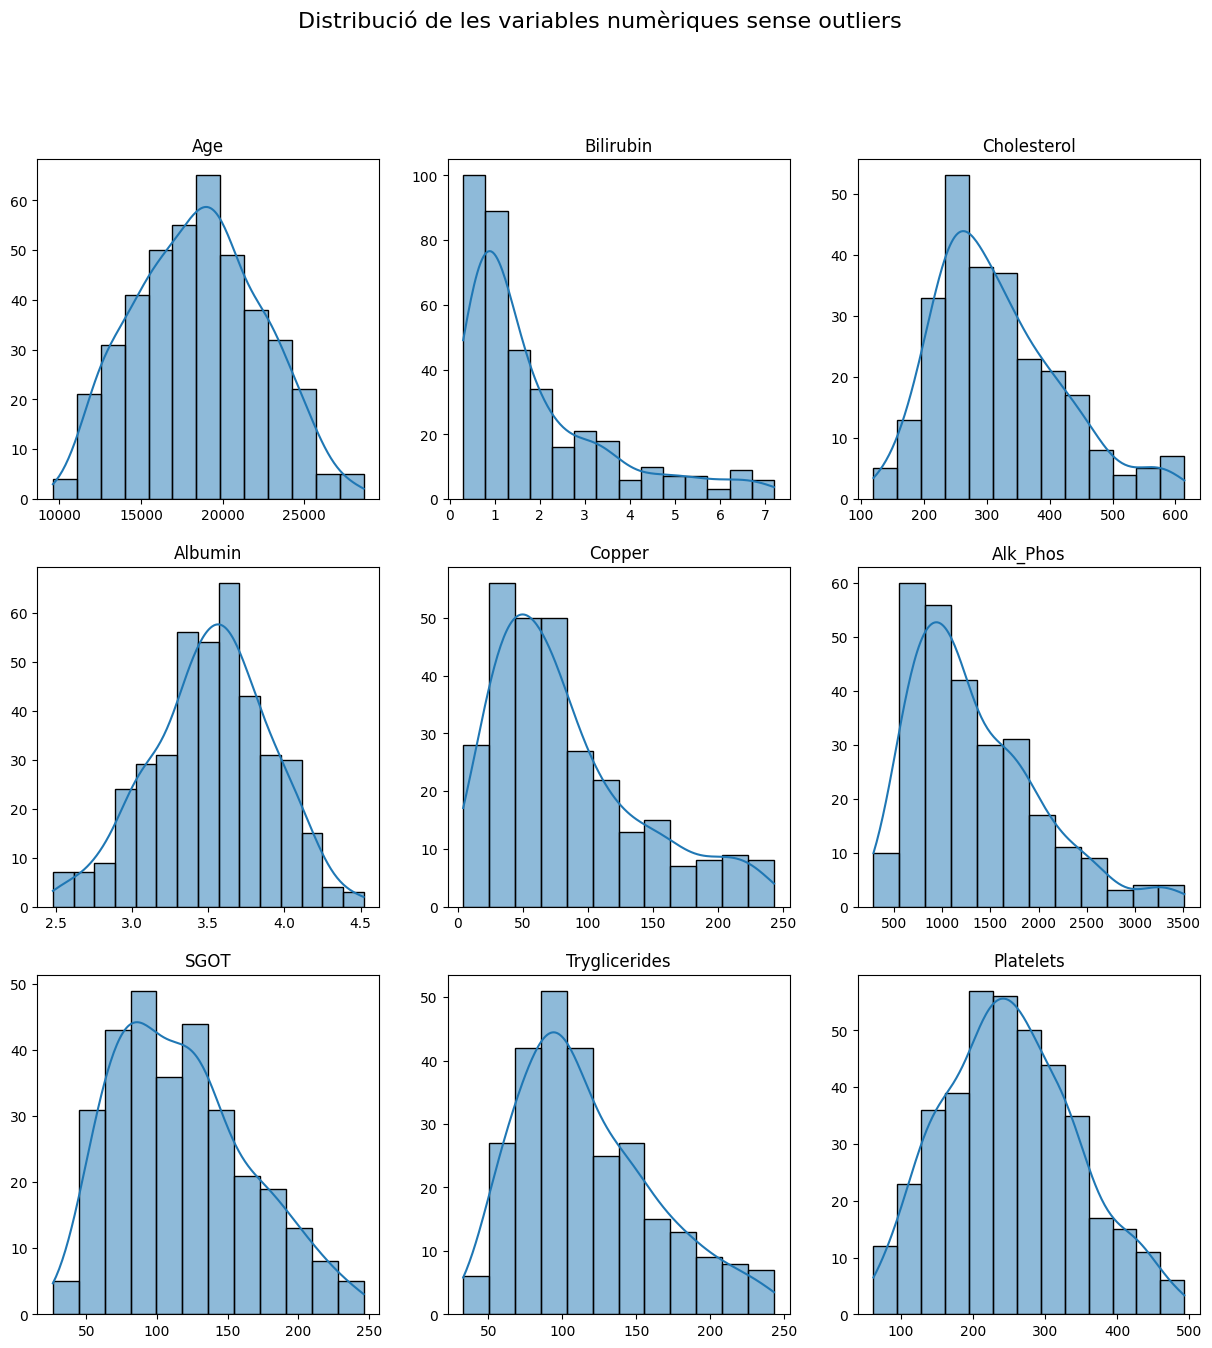

In [ ]:
# Creo una figura que tindrà 9 gràfics de distribució de les variables numèriques sense outliers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribució de les variables numèriques sense outliers', fontsize=16)

# Creo un for que em recorri les variables numèriques
for ax, var in zip(axes.flatten(), numeric_variables):
    sns.histplot(data=df, x=var, kde=True, ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')
    ax.set_ylabel('')

var_sense_out = plot_to_str()




### 1.5 Recodificació de variables

In [ ]:
# Per a la variable Status
df['Status'] = df['Status'].replace('C', 0.0)
df['Status'] = df['Status'].replace('CL', 1.0)
df['Status'] = df['Status'].replace('D', 2.0)

# Per a la variable Drug
df['Drug'] = df['Drug'].replace('D-penicillamine', 0.0)
df['Drug'] = df['Drug'].replace('Placebo', 1.0)

# Per a la variable Sex
df['Sex'] = df['Sex'].replace('F', 0.0)
df['Sex'] = df['Sex'].replace('M', 1.0)

# Per a la variable Ascites
df['Ascites'] = df['Ascites'].replace('N', 0.0)
df['Ascites'] = df['Ascites'].replace('Y', 1.0)

# Per a la variable Hepatomegaly
df['Hepatomegaly'] = df['Hepatomegaly'].replace('N', 0.0)
df['Hepatomegaly'] = df['Hepatomegaly'].replace('Y', 1.0)

# Per a la variable Spiders
df['Spiders'] = df['Spiders'].replace('N', 0.0)
df['Spiders'] = df['Spiders'].replace('Y', 1.0)

# Per a la variable Edema
df['Edema'] = df['Edema'].replace('N', 0.0)
df['Edema'] = df['Edema'].replace('S', 0.5)
df['Edema'] = df['Edema'].replace('Y', 1.0)

In [ ]:
# Guardem el dataset sense outliers ni variables categòriques a un nou csv
df.to_csv('cirrhosis_sense_outliers.csv', index=False)
# Mida del dataset en files
print('El dataset té ' + str(df.shape[0]) + ' files.')

El dataset té 418 files.


In [ ]:
for av in all_variables:
    df[av] = pd.to_numeric(df[av], errors='coerce')

### 1.6 Particionat del dataset


In [ ]:
X_nou = df.drop('Status', axis=1)
y_nou = df['Status']

In [ ]:
# Fem la partició
X_train, X_test, y_train, y_test = train_test_split(X_nou, y_nou, test_size=0.3, random_state=42)

### 1.3.2 Gestió dels missings:

In [ ]:
# Comprovem quants missings hi ha a cada conjunt
print('Missings a X_train:', X_train.isnull().sum().sum())
print('Missings a X_test:', X_test.isnull().sum().sum())

Missings a X_train: 779
Missings a X_test: 422


In [ ]:
variables_sense_status = ['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

In [ ]:
# Ara podem aplicar MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Passem a DataFrame
X_train = pd.DataFrame(X_train, columns=variables_sense_status)
X_test = pd.DataFrame(X_test, columns=variables_sense_status)

In [ ]:
variables_categoriques = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

In [ ]:
# Aquestes variables_categories les imputarem amb la moda
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X_train[variables_categoriques])
X_train[variables_categoriques] = imputer.transform(X_train[variables_categoriques])
X_test[variables_categoriques] = imputer.transform(X_test[variables_categoriques])

# Crear una instància de IterativeImputer per aplicar MICE
# mice_imputer = IterativeImputer()
# mice_imputer.fit(X_train[variables_categoriques])
# X_train[variables_categoriques] = mice_imputer.transform(X_train[variables_categoriques])
# X_test[variables_categoriques] = mice_imputer.transform(X_test[variables_categoriques])

In [ ]:
# Imprimeix el nombre de missings que hi ha a cada conjunt
print('Missings a X_train:', X_train.isnull().sum().sum())
print('Missings a X_test:', X_test.isnull().sum().sum())

Missings a X_train: 504
Missings a X_test: 267


In [ ]:
# Imputem els valors missings amb KNNImputer
imputer = KNNImputer(n_neighbors=5)

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# X_train i test amb escalar i imputar a csv
X_train = pd.DataFrame(X_train, columns=variables_sense_status)
X_test = pd.DataFrame(X_test, columns=variables_sense_status)

In [ ]:
# Comprovem quants missings hi ha a cada conjunt
print('Missings a X_train després d\'imputar:', X_train.isnull().sum().sum())
print('Missings a X_test després d\'imputar:', X_test.isnull().sum().sum())

Missings a X_train després d'imputar: 0
Missings a X_test després d'imputar: 0


In [ ]:
# Guardem el train i test en dos nous csv
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

## SECCIÓ 2. Preparació de variables

### 2.2 Anàlisi de correlacions entre variables numèriques

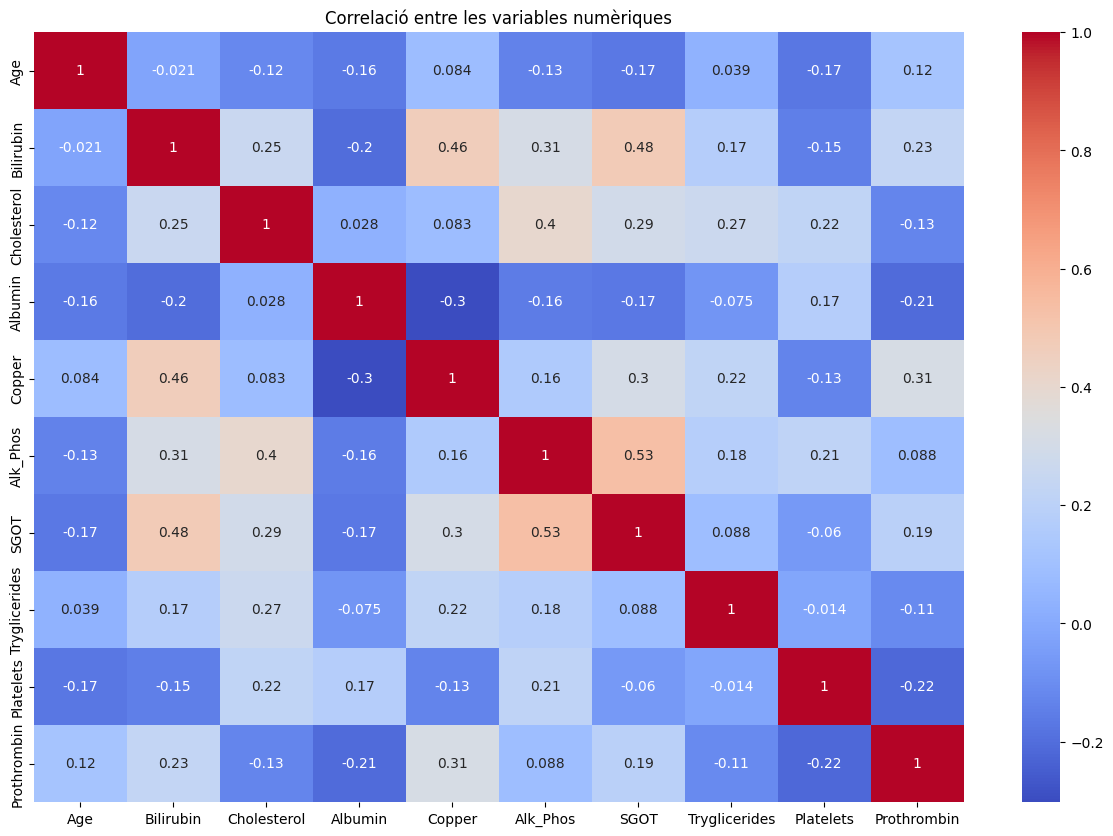

<Figure size 640x480 with 0 Axes>

In [ ]:
# Aquí farem un anèlisi de correlació entre les variables numèriques
df_num_variables = df[numeric_variables]

plt.figure(figsize=(15, 10))
sns.heatmap(df_num_variables.corr(), annot=True, cmap='coolwarm')
plt.title('Correlació entre les variables numèriques')
plt.show()

num_var_corr = plot_to_str()

### 2.3 Anàlisi de variables categòriques i variable objectiu

Només per aquesta figura torno a reanomenar els valors com els teníem abans:

In [ ]:
data_figures = df.copy()

# Només per aquests plots reanomenarem els valors com abans
data_figures['Status'] = data_figures['Status'].replace(0.0, 'C')
data_figures['Status'] = data_figures['Status'].replace(1.0, 'CL')
data_figures['Status'] = data_figures['Status'].replace(2.0, 'D')

data_figures['Drug'] = data_figures['Drug'].replace(0.0, 'D-penicillamine')
data_figures['Drug'] = data_figures['Drug'].replace(1.0, 'Placebo')

data_figures['Sex'] = data_figures['Sex'].replace(0.0, 'F')
data_figures['Sex'] = data_figures['Sex'].replace(1.0, 'M')

data_figures['Ascites'] = data_figures['Ascites'].replace(0.0, 'N')
data_figures['Ascites'] = data_figures['Ascites'].replace(1.0, 'Y')

data_figures['Hepatomegaly'] = data_figures['Hepatomegaly'].replace(0.0, 'N')
data_figures['Hepatomegaly'] = data_figures['Hepatomegaly'].replace(1.0, 'Y')

data_figures['Spiders'] = data_figures['Spiders'].replace(0.0, 'N')
data_figures['Spiders'] = data_figures['Spiders'].replace(1.0, 'Y')

data_figures['Edema'] = data_figures['Edema'].replace(0.0, 'N')
data_figures['Edema'] = data_figures['Edema'].replace(0.5, 'S')
data_figures['Edema'] = data_figures['Edema'].replace(1.0, 'Y')

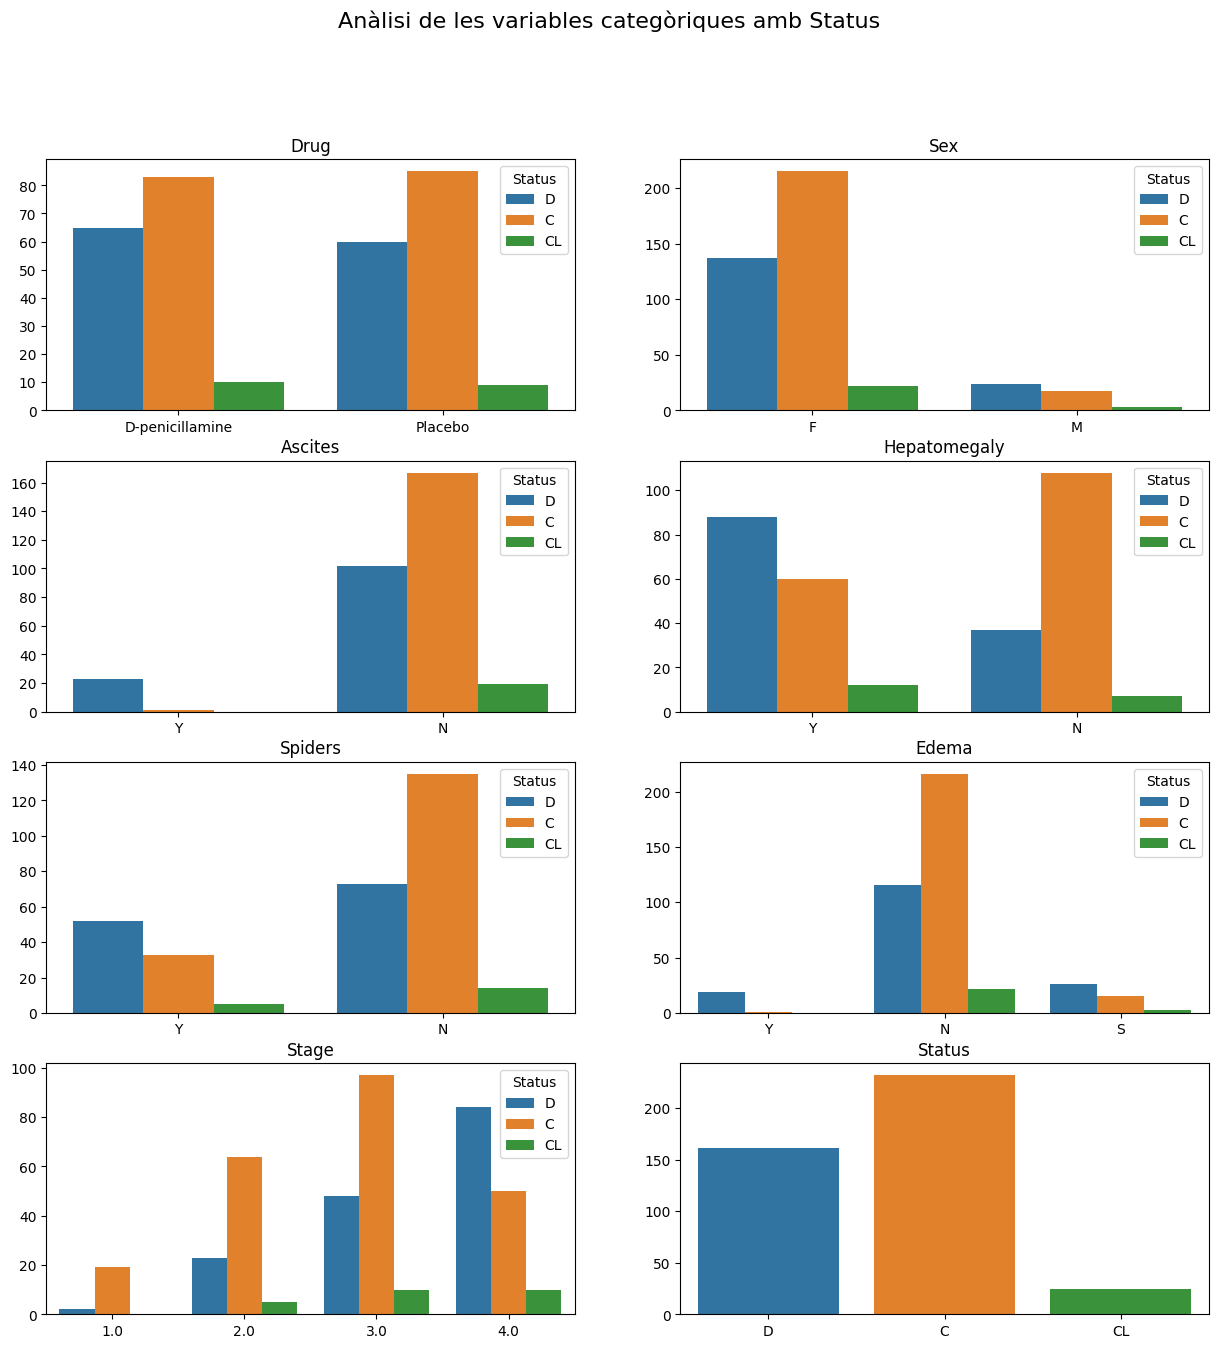

In [ ]:
# Per fer l'anàlisi de les categòriques amb 'Status' farem un gràfic bivariable

var_categoriques_amb_status = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage','Status']

# Fem una figura de 4x2 fent que no es mostri el gràfic buit
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.suptitle('Anàlisi de les variables categòriques amb Status', fontsize=16)

# Creo un for que em recorri les variables categòriques
for ax, var in zip(axes.flatten(), var_categoriques_amb_status):
    sns.countplot(data=data_figures, x=var, hue='Status', ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')
    ax.set_ylabel('')

### 2.4 Eliminació de variables redundants o sorolloses

In [ ]:
# Elimino aquelles variables que no aporten res, recordem que 'ID' ha estat eliminada prèviament
df = df.drop('Drug', axis=1)
X_train = X_train.drop('Drug', axis=1)
X_test = X_test.drop('Drug', axis=1)

### 2.5 Estudi de dimensionalitat amb PCA

In [ ]:
# Farem un estudi de la dimensionalitat del dataset utilitzant PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
explained_variance_ratio = pca.explained_variance_ratio_

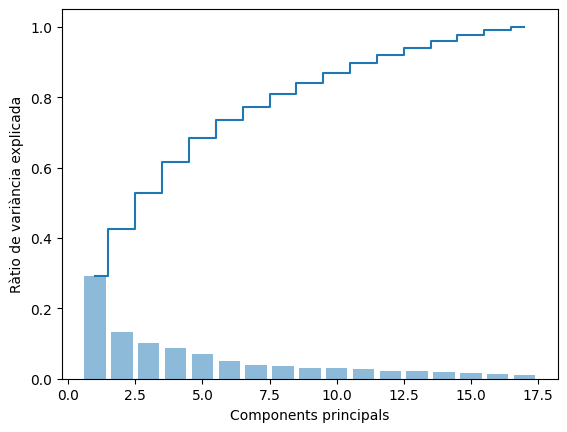

In [ ]:
# Mostrem la figura
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid')
plt.ylabel('Ràtio de variància explicada')
plt.xlabel('Components principals')
plt.show()

Faré la reducció a 5 components principals utilitzant PCA:

In [ ]:
# A partir de la figura anterior podem veure que amb 5 components principals podem explicar més del 90% de la variància del dataset
# Per tant, aplicarem PCA amb 5 components principals
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Creem un nou DataFrame amb les 5 components principals
X_train = pd.DataFrame(X_train_pca)
X_test = pd.DataFrame(X_test_pca)

In [ ]:
# Creem un nou csv amb les 5 components principals
X_train.to_csv('X_train_pca.csv', index=False)
X_test.to_csv('X_test_pca.csv', index=False)

## SECCIÓ 3. Definició de models

Tots els models els entrenaré utilitzant cross validation i grid search

### 3.1.1 Definició de mètriques per a un KNN

In [ ]:
# Definim els paràmetres per a KNN
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=100)
knn_cv.fit(X_train, y_train)

# Mostrem els millors paràmetres
print('Els millors paràmetres per a un KNN són:', knn_cv.best_params_)

/Users/jaumemil/Desktop/IA/2n/IAA/Pràctica IAA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 18 members, which is less than n_splits=100.
  warnings.warn(


Els millors paràmetres per a un KNN són: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [ ]:
# Creem un DataFrame amb els resultats de GridSearchCV
results = pd.DataFrame(knn_cv.cv_results_)

# Seleccionem les columnes que ens interessen
results = results[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score']]

# Canviem el nom de les columnes per a que siguin més comprensibles
results.columns = ['N Neighbors', 'Weights', 'Metric', 'Mean Test Score']

# Mostrem results ordenat per mean_test_score
results = results.sort_values(by='Mean Test Score', ascending=False)
results.head()

,N Neighbors,Weights,Metric,Mean Test Score
37,19,distance,manhattan,0.736667
39,21,distance,manhattan,0.731667
12,15,uniform,euclidean,0.726667
52,15,uniform,minkowski,0.726667
33,15,distance,manhattan,0.726667


### 3.1.2 Definició de mètriques per a un arbre de decisió

AVÍS!!! La definició dels paràmetres a mi em triga uns 2 min en executar.

In [ ]:
# Definim els paràmetres per a Decision Tree

tree_params = {'criterion': ['gini', 'entropy'],
                'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                'min_samples_split': [2, 5, 10, 15, 20],
                'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, tree_params, cv=100)
tree_cv.fit(X_train, y_train)

# Mostrem els millors paràmetres
print('Els millors paràmetres per a un DecisionTree són:', tree_cv.best_params_)


/Users/jaumemil/Desktop/IA/2n/IAA/Pràctica IAA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 18 members, which is less than n_splits=100.
  warnings.warn(


Els millors paràmetres per a un DecisionTree són: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}


In [ ]:
# Creem un DataFrame amb els resultats de GridSearchCV
results = pd.DataFrame(tree_cv.cv_results_)

# Seleccionem les columnes que ens interessen
results = results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]

# Canviem el nom de les columnes per a que siguin més comprensibles
results.columns = ['Criterion', 'Max Depth', 'Min Samples Split', 'Min Samples Leaf', 'Mean Test Score']

# Mostrem results ordenat per mean_test_score i en cas d'empat per Min Samples Split de manera ascendent
results = results.sort_values(by=['Mean Test Score', 'Min Samples Split'], ascending=[False, True])
results.head()

,Criterion,Max Depth,Min Samples Split,Min Samples Leaf,Mean Test Score
185,gini,4,2,8,0.775
186,gini,4,5,8,0.775
187,gini,4,10,8,0.775
188,gini,4,15,8,0.775
189,gini,4,20,8,0.775


### 3.1.3 Definició de paràmetres per a un SVM

In [ ]:
# Definim els paràmetres per a SVM

svm_params = {'C': [0.1, 1, 10, 100, 1000],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'gamma': ['scale', 'auto']}
svm = SVC()
svm_cv = GridSearchCV(svm, svm_params, cv=100)
svm_cv.fit(X_train, y_train)

# Mostrem els millors paràmetres
print('Els millors paràmetres per a un SVM són:', svm_cv.best_params_)

/Users/jaumemil/Desktop/IA/2n/IAA/Pràctica IAA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 18 members, which is less than n_splits=100.
  warnings.warn(


Els millors paràmetres per a un SVM són: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# Creem un DataFrame amb els resultats de GridSearchCV
results = pd.DataFrame(svm_cv.cv_results_)

# Seleccionem les columnes que ens interessen
results = results[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score']]

# Canviem el nom de les columnes per a que siguin més comprensibles
results.columns = ['C', 'Kernel', 'Gamma', 'Mean Test Score']

# Mostrem results ordenat per mean_test_score i en cas d'empat per C de manera ascendent
results = results.sort_values(by=['Mean Test Score', 'C'], ascending=[False, True])
results.head()

,C,Kernel,Gamma,Mean Test Score
14,1,rbf,auto,0.745000
18,10,rbf,scale,0.745000
22,10,rbf,auto,0.743333
15,1,sigmoid,auto,0.741667
17,10,poly,scale,0.738333


### 3.2.1 Entrenament del KNN

In [ ]:
# Creem el model amb els paràmetres optimitzats
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')

# Entrenem el model
knn.fit(X_train, y_train)

# Fem prediccions amb les dades de test
y_pred = knn.predict(X_test)

# Convertim y_test i y_pred a un format que les mètriques de classificació puguin entendre
y_test = y_test.astype('int')
y_pred_knn = y_pred.astype('int')

### 3.3.1 Avaluació del KNN

In [ ]:
# Afegim aquests resultats en un dataframe
results = pd.DataFrame({'Model': ['KNN'],
                        'Accuracy': [accuracy_score(y_test, y_pred_knn)],
                        'Precision': [precision_score(y_test, y_pred_knn, average='weighted', zero_division=1)],
                        'Recall': [recall_score(y_test, y_pred_knn, average='weighted')],
                        'F1 Score': [f1_score(y_test, y_pred_knn, average='weighted')]})

#Mostrem els resultats sense la columna index
results

,Model,Accuracy,Precision,Recall,F1 Score
0,KNN,0.753968,0.733552,0.753968,0.729078


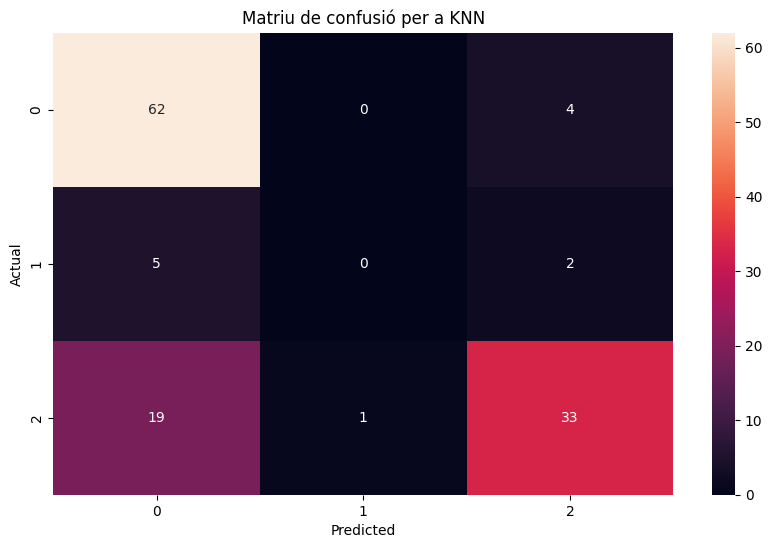

In [ ]:
# Mostrem una matriu de confusió

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='g')
plt.title('Matriu de confusió per a KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 3.1.2 Entrenament del DecisionTree

In [ ]:
# Ara entrenarem el model utilitzant un arbre de decisió
# Creem el model
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=8, min_samples_split=2, random_state=42)

# Entrenem el model
tree.fit(X_train, y_train)

# Fem prediccions amb les dades de test
y_pred = tree.predict(X_test)

# Convertim y_test i y_pred a un format que les mètriques de classificació puguin entendre
y_test = y_test.astype('int')
y_pred_tree = y_pred.astype('int')

### 3.2.2 Avaluació del DecisionTree

In [ ]:
# Fiquem aquests resultats en un dataframe
results = pd.DataFrame({'Model': ['DecisionTree'],
                        'Accuracy': [accuracy_score(y_test, y_pred_tree)],
                        'Precision': [precision_score(y_test, y_pred_tree, average='weighted', zero_division=1)],
                        'Recall': [recall_score(y_test, y_pred_tree, average='weighted')],
                        'F1 Score': [f1_score(y_test, y_pred_tree, average='weighted')]})

#Mostrem els resultats sense la columna index
results

,Model,Accuracy,Precision,Recall,F1 Score
0,DecisionTree,0.730159,0.751091,0.730159,0.705431


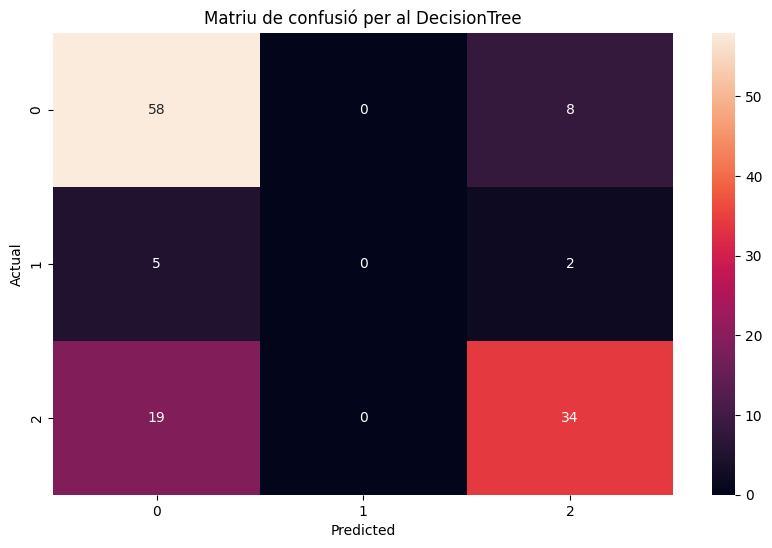

In [ ]:
# Mostrem una matriu de confusió
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='g')
plt.title('Matriu de confusió per al DecisionTree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 3.1.3 Entrenament del SVM

In [ ]:
# Ara entrenarem el model utilitzant un SVM

# Creem el model amb els paràmetres que hem trobat i random_state 42
svm = SVC(C=1, gamma='auto', kernel='rbf', random_state=42)

# Entrenem el model
svm.fit(X_train, y_train)

# Fem prediccions amb les dades de test
y_pred = svm.predict(X_test)

# Convertim y_test i y_pred a un format que les mètriques de classificació puguin entendre
y_test = y_test.astype('int')
y_pred_svm = y_pred.astype('int')

### 3.2.3 Avaluació del SVM

In [ ]:
# Fiquem aquests resultats en un dataframe
results = pd.DataFrame({'Model': ['SVM'],
                        'Accuracy': [accuracy_score(y_test, y_pred_svm)],
                        'Precision': [precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)],
                        'Recall': [recall_score(y_test, y_pred_svm, average='weighted')],
                        'F1 Score': [f1_score(y_test, y_pred_svm, average='weighted')]})

#Mostrem els resultats sense la columna index
results

,Model,Accuracy,Precision,Recall,F1 Score
0,SVM,0.738095,0.763863,0.738095,0.711612


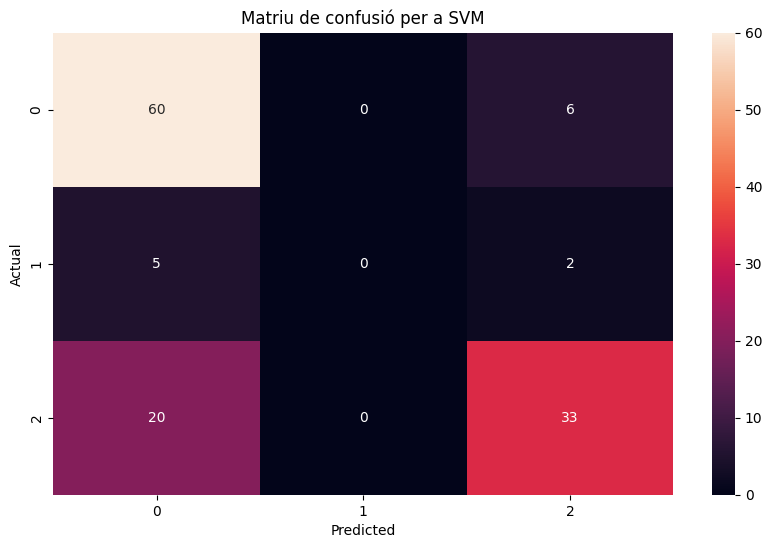

In [ ]:
# Mostrem una matriu de confusió
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='g')
plt.title('Matriu de confusió per a SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## SECCIÓ 4. Definició del model triat

### 4.3 Comparació entre els resultats de train i test del KNN

In [ ]:
# Creem un DataFrame amb els resultats de train i test del KNN

resultats_knn = pd.DataFrame({'Accuracy': [accuracy_score(y_train, knn.predict(X_train)), accuracy_score(y_test, knn.predict(X_test))],
                            'Precisió': [precision_score(y_train, knn.predict(X_train), average='weighted', zero_division=1), precision_score(y_test, knn.predict(X_test), average='weighted', zero_division=1)],
                            'Recall': [recall_score(y_train, knn.predict(X_train), average='weighted'), recall_score(y_test, knn.predict(X_test), average='weighted')],
                            'F1 score': [f1_score(y_train, knn.predict(X_train), average='weighted'), f1_score(y_test, knn.predict(X_test), average='weighted')]},
                            index=['Train', 'Test'])

# Mostrem la taula
print('Resultats de train i test del KNN:')
resultats_knn

Resultats de train i test del KNN:


,Accuracy,Precisió,Recall,F1 score
Train,1.000000,1.000000,1.000000,1.000000
Test,0.753968,0.733552,0.753968,0.729078


## SECCIÓ 5. Model Card

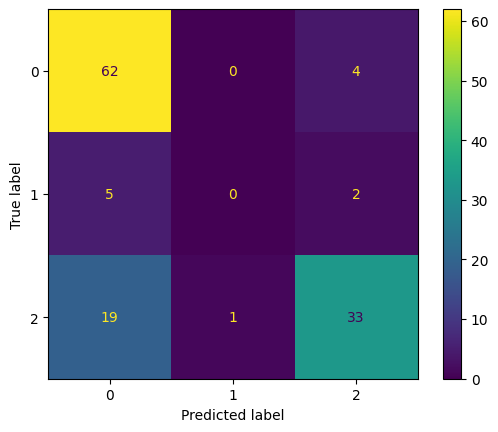

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
conf_matrix = plot_to_str()

In [ ]:
toolkit = mct.ModelCardToolkit()

model_card = toolkit.scaffold_assets()

In [ ]:
model_card.model_details.name = 'Cirrhosis Patient Survival Prediction Dataset'
model_card.model_details.overview = (
    'Aquest model prediu la supervivència de pacients amb cirrosi hepàtica, donades 17 característiques clíniques.'
    'Aquest model està entrenat amb un algorisme de KNN. És un algorisme paràmetric i que'
'es basa en la distancia manhattan als 19 veïns més propers per assignar mostres. Els '
'hiperparàmetres que s\'han hagut de controlar són el número de veïns, la mètrica i la distància.'
)
model_card.model_details.owners = [
    mct.Owner(name= 'Jaume Mora i Ladària (Alumne del Grau en Intel·ligència Artificial)', contact='jaume.mora.ladaria@estudiantat.upc.edu')
]
model_card.model_details.references = [
    mct.Reference(reference='https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+ survival+prediction+dataset-1'),
]
model_card.model_details.version.name = str(1.0)
model_card.model_details.version.date = str(date.today())

model_card.considerations.ethical_considerations = [mct.Risk(
    name=('Hem de complir les normes de privacitat en tot moment, estem tractant amb dades mèdiques.'),
    mitigation_strategy='S\'estan complint.'
)]
model_card.considerations.limitations = [mct.Limitation(description='Les limitacions del KNN són diverses: sensibilitat a la mida del dataset i a la K, ineficiènica amb els datasets grans,'
                      'sensibilitat a les variables irrellevants, necessitat d\’una normalització i/o estandardització de les dades i sensibilitat als outliers.'

)]
model_card.considerations.use_cases = [mct.UseCase(description='La intenció d\'ús d\'aquest model és per un treball en el qual he d\'aprendre a utilitzar'
'i comparar diferents models, mitjançant una tasca d\'aprenentatge supervisat en el qual es pretén predir'
'la supervivència o no d\'uns pacients amb cirrhosi hepàtica. Aquest model no té cap intenció en ser usat per a'
'realitzar cap diagnostic real o negoci.')]
model_card.considerations.users = [mct.User(description='Professors i estudiants de IAA')]

model_card.model_parameters.data.append(mct.Dataset())
model_card.model_parameters.data[0].graphics.description = (
  f'Comparació de les variables numèriques amb i sense outliers')
model_card.model_parameters.data[0].graphics.collection = [
    mct.Graphic(image=var_out),
    mct.Graphic(image=var_sense_out),
]

model_card.quantitative_analysis.graphics.description = (
  'Matriu de confusió')
model_card.quantitative_analysis.graphics.collection = [
    mct.Graphic(image=conf_matrix)
]

toolkit.update_model_card(model_card)

In [ ]:
# Return the model card document as an HTML page

html = toolkit.export_format()

display.display(display.HTML(html))

## SECCIÓ 6. Bonus

### 6.1. Model EBM

In [ ]:
# Ara entrenarem un model EBM amb les dades de train i test
# Creem el model
ebm = ExplainableBoostingClassifier(random_state=42)

# Entrenem el model
ebm.fit(X_train, y_train)

# Fem prediccions amb les dades de test
y_pred = ebm.predict(X_test)

# Convertim y_test i y_pred a un format que les mètriques de classificació puguin entendre
y_test = y_test.astype('int')
y_pred_ebm = y_pred.astype('float').astype('int')

/Users/jaumemil/Desktop/IA/2n/IAA/Pràctica IAA/.venv/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:934: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


In [ ]:
# Fiquem aquests resultats en un dataframe
results = pd.DataFrame({'Model': ['EBM'],
                        'Accuracy': [accuracy_score(y_test, y_pred_ebm)],
                        'Precision': [precision_score(y_test, y_pred_ebm, average='weighted', zero_division=1)],
                        'Recall': [recall_score(y_test, y_pred_ebm, average='weighted')],
                        'F1 Score': [f1_score(y_test, y_pred_ebm, average='weighted')]})

#Mostrem els resultats sense la columna index
results

,Model,Accuracy,Precision,Recall,F1 Score
0,EBM,0.753968,0.780285,0.753968,0.727499


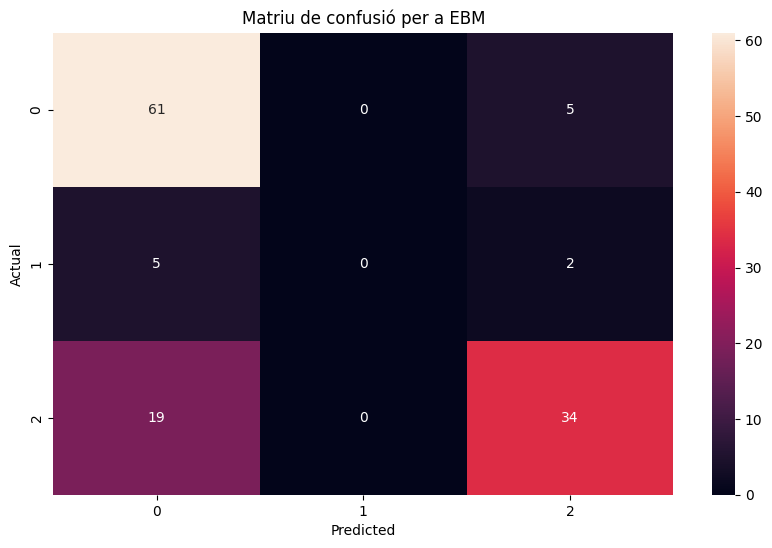

In [ ]:
# Mostrem una matriu de confusió 
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_ebm), annot=True, fmt='g')
plt.title('Matriu de confusió per a EBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()